In [ ]:
#deep dream

Step 0, loss 0.9129872918128967
Step 50, loss 3.0631284713745117
Step 100, loss 3.5886573791503906
Step 150, loss 3.9341888427734375
Step 200, loss 4.211343288421631
Step 250, loss 4.454897403717041
Step 300, loss 4.680789470672607
Step 350, loss 4.893570899963379
Step 400, loss 5.091896057128906
Step 450, loss 5.278477191925049
Step 500, loss 5.451096057891846
Step 550, loss 5.610526084899902
Step 600, loss 5.758613586425781
Step 650, loss 5.896795749664307
Step 700, loss 6.026499271392822
Step 750, loss 6.146335601806641
Step 800, loss 6.256503105163574
Step 850, loss 6.359315395355225
Step 900, loss 6.454466819763184
Step 950, loss 6.5450639724731445
Step 1000, loss 6.631808280944824
Step 1050, loss 6.710587978363037
Step 1100, loss 6.786003589630127
Step 1150, loss 6.85648250579834
Step 1200, loss 6.921473503112793
Step 1250, loss 6.983241558074951
Step 1300, loss 7.041627407073975
Step 1350, loss 7.097756385803223
Step 1400, loss 7.150734901428223
Step 1450, loss 7.201364994049072

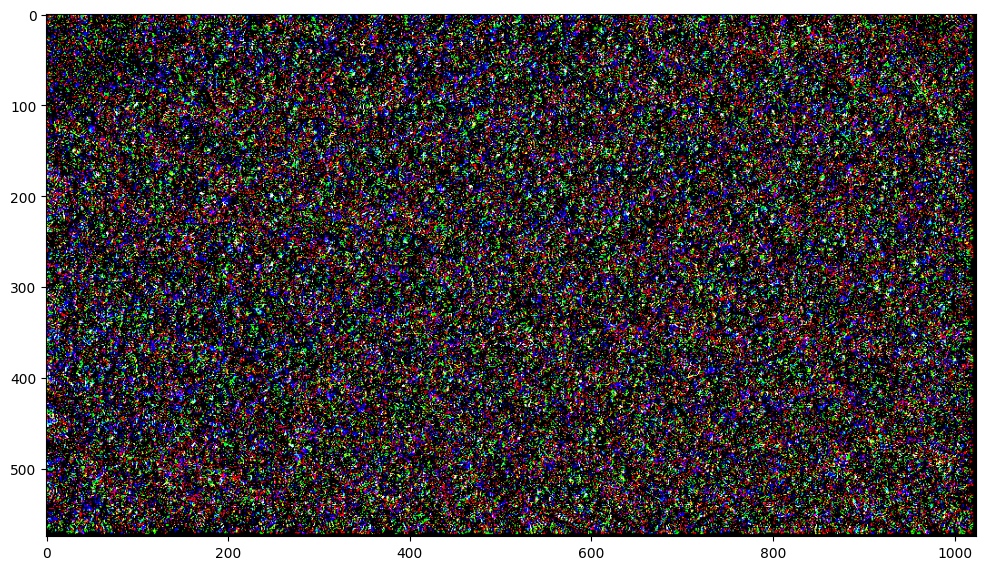

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the pre-trained InceptionV3 model
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

# Define layers to contribute to the loss
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create a feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

def calc_loss(img, model):
    img_tensor = tf.convert_to_tensor(img)
    layer_activations = model(img_tensor)
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return  tf.reduce_sum(losses)

@tf.function
def deepdream_step(img, step_size):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = calc_loss(img, dream_model)

    gradients = tape.gradient(loss, img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)
    return loss, img


def run_deep_dream_simple(img, steps=5000, step_size=0.02):  # Increase steps and step size
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    img = tf.convert_to_tensor(img)
    for step in range(steps):
        loss, img = deepdream_step(img, step_size)
        if step % 50 == 0:  # Log progress every 50 steps
            print("Step {}, loss {}".format(step, loss))
    img = tf.squeeze(img)  # Remove batch dimension
    return img


def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Load your image
original_img = image.load_img('/content/sky1024px.jpg')
original_img = image.img_to_array(original_img)

# Run deepdream
dream_img = run_deep_dream_simple(original_img, steps=10000, step_size=0.01)

# Display the dream image
plt.figure(figsize=(12, 12))
plt.imshow(dream_img.numpy().astype(np.uint8))
plt.show()
